# Task 1 : Set up colab gpu runtime environment

In [ ]:
# Install necessary libraries for segmentation, augmentation, and image processing
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fanof5_q
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fanof5_q
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
# Clone the dataset repository from GitHub
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


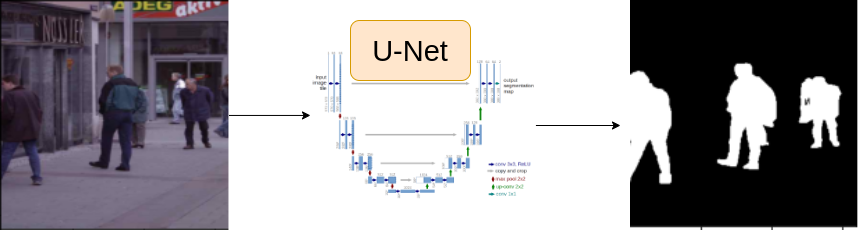

# Some Common Imports

In [ ]:
# Add the dataset directory to the system path for easier imports
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [2]:
# Import essential libraries for PyTorch, image processing, data manipulation, and plotting
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper # Assuming 'helper' contains utility functions like show_image

# Task : 2 Setup Configurations

In [ ]:
# Define configuration parameters for the dataset, training, and model
CSV_FILE= '/content/Human-Segmentation-Dataset-master/train.csv' # Path to the training CSV file
DATA_DIR= '/content/' # Data directory
DEVICE = 'cuda' # Device to use for training (GPU if available, otherwise CPU)

Epochs = 25 # Number of training epochs
LR = .003 # Learning rate for the optimizer
Img_size = 320 # Image size for resizing
Batch_size = 16 # Batch size for data loaders

ENCODER = 'timm-efficient-b0' # Encoder model for the segmentation network
weights = 'imagenet' # Pre-trained weights for the encoder

In [ ]:
# Read the training CSV file into a pandas DataFrame
df = pd.read_csv(CSV_FILE)
# Display the first few rows of the DataFrame
display(df.head())

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
# Select the first row of the DataFrame
row = df.iloc[0]

# Get the image and mask paths from the selected row
image_path = row.images
mask_path = row.masks

# Read the image using OpenCV and convert it from BGR to RGB
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the mask in grayscale and normalize pixel values to the range [0, 1]
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

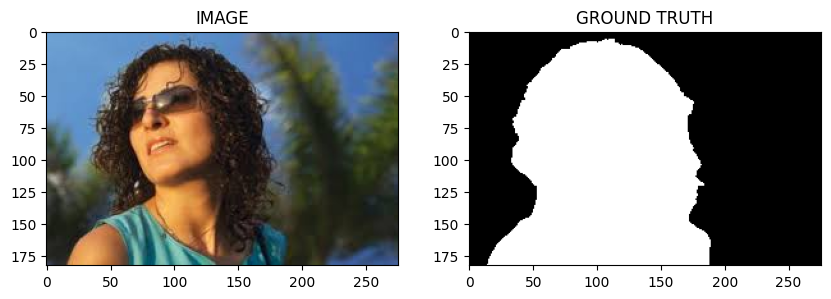

In [ ]:
# Create a figure with two subplots to display the image and its corresponding mask
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Display the original image in the first subplot
ax1.set_title('IMAGE')
ax1.imshow(image)

# Display the ground truth mask in the second subplot in grayscale
ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# Split the DataFrame into training and validation sets
train_df, valid_df = train_test_split(df, test_size = .2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
# Import the Albumentations library for image augmentation
import albumentations as A

In [ ]:
import albumentations as A

# Define augmentation pipeline for training data
def get_train_augs():
  return A.Compose([
      A.Resize(Img_size, Img_size), # Resize images and masks to the specified size
      A.HorizontalFlip(p = .5), # Apply horizontal flip with a probability of 0.5
      A.VerticalFlip(p = .5) # Apply vertical flip with a probability of 0.5

  ], is_check_shapes=False) # Disable shape check for now

# Define augmentation pipeline for validation data (only resizing)
def get_valid_augs():
  return A.Compose([
      A.Resize(Img_size, Img_size), # Resize images and masks to the specified size
  ], is_check_shapes=False) # Disable shape check for now

# Task 4 : Create Custom Dataset

In [ ]:
# Import the Dataset class from PyTorch
from torch.utils.data import Dataset

In [ ]:
# Define a custom Dataset class for human segmentation
class SegmnentationDataset(Dataset):
  def __init__(self, df, augmentations):
    # Initialize with DataFrame and augmentation transformations
    self.df=df
    self.augmentations = augmentations
  def __len__(self):
    # Return the number of samples in the dataset
    return len(self.df)
  def __getitem__(self, idx):
    # Get the image and mask paths for a given index
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    # Read the image and mask using OpenCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply augmentations if provided
    if self.augmentations:
      data=self.augmentations(image= image, mask=mask)
      image=data['image']
      mask = data['mask']

    #[h,w,c] -> (c,h,w)
    # Transpose the image dimensions to (C, H, W) and convert to float32
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    # Add a channel dimension to the mask (1, H, W) and convert to float32
    mask = np.expand_dims(mask, axis=0).astype(np.float32)

    # Convert numpy arrays to PyTorch tensors and normalize image
    image = torch.Tensor(image) /255.0
    # Convert mask to PyTorch tensor and round to binary values (0 or 1)
    mask = torch.round(torch.Tensor(mask) /255.0)


    return image, mask

In [ ]:
# Create instances of the custom dataset for training and validation
trainset = SegmnentationDataset(train_df, get_train_augs())
validset = SegmnentationDataset(valid_df, get_valid_augs())

In [ ]:
# Print the size of the training and validation datasets
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


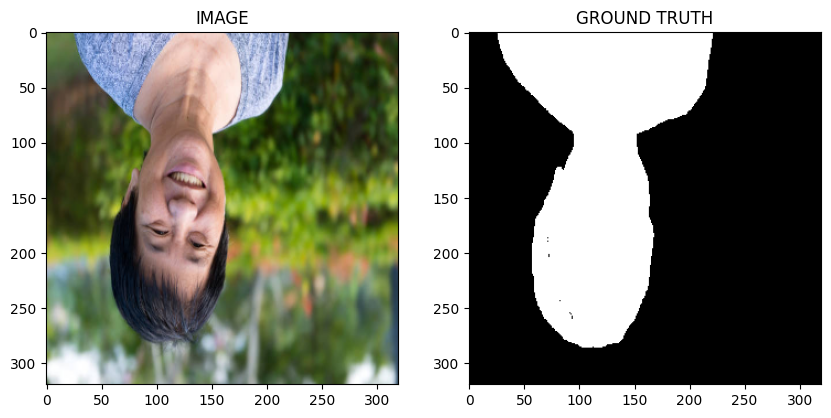

In [ ]:
# Get an example image and mask from the training set
idx = 3
image, mask = trainset[idx]
# Display the image and mask using the helper function
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
# Import the DataLoader class from PyTorch
from torch.utils.data import DataLoader

In [ ]:
# Create DataLoaders for the training and validation sets
trainloader = DataLoader(trainset, batch_size=(Batch_size), shuffle=True) # Shuffle training data
validloader = DataLoader(validset, batch_size=(Batch_size)) # Do not shuffle validation data

In [ ]:
# Print the total number of batches in the training and validation DataLoaders
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
# Get one batch of images and masks from the training DataLoader
for image, mask in trainloader:
  break
# Print the shapes of the image and mask tensors in the batch
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
# Import necessary modules from PyTorch and segmentation_models_pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

# Define the Segmentation Model using a U-Net architecture
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    # Initialize the U-Net model with a specified encoder, weights, and output channels
    self.arc = smp.Unet(
        encoder_name = 'efficientnet-b0', # Encoder architecture
        encoder_weights= weights, # Pre-trained weights for the encoder
        in_channels=3, # Number of input channels (RGB)
        classes=1, # Number of output classes (1 for binary segmentation)
        activation = None # No activation on the output logits
    )
  def forward(self, images, masks = None):
    # Forward pass through the U-Net model
    logits = self.arc(images)

    # Calculate loss if masks are provided (during training or validation)
    if masks is not None:
      # Calculate Dice loss (common for segmentation tasks)
      loss1 = DiceLoss(mode='binary')(logits, masks)
      # Calculate Binary Cross-Entropy with Logits loss
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      # Return logits and the sum of the two losses
      return logits, loss1+loss2
    # Return only logits during inference
    return logits

In [ ]:
# Create an instance of the SegmentationModel and move it to the specified device (GPU)
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_expand_conv): Identity()
          (_bn0): Identity()
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32,

# Task 7 : Create Train and Validation Function

In [ ]:
# Define the training function
def train_fn(data_loader, model, optimizer):

  # Set the model to training mode
  model.train()
  total_loss=0
  # Iterate over the data loader
  for images,masks in tqdm(data_loader):
    # Move images and masks to the specified device
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    # Zero the gradients
    optimizer.zero_grad()
    # Forward pass and calculate loss
    logits, loss = model(images, masks)
    # Backpropagate the loss
    loss.backward()
    # Update model parameters
    optimizer.step()

    # Accumulate the total loss
    total_loss += loss.item()

  # Return the average loss over the dataset
  return total_loss / len(data_loader)

In [ ]:
# Define the evaluation function
def eval_fn(data_loader, model):

  # Set the model to evaluation mode
  model.eval()
  total_loss=0

  # Disable gradient calculation during evaluation
  with torch.no_grad():
    # Iterate over the data loader
    for images,masks in tqdm(data_loader):
      # Move images and masks to the specified device
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      # Forward pass and calculate loss
      logits, loss = model(images, masks)

      # Accumulate the total loss
      total_loss += loss.item()

    # Return the average loss over the dataset
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
# Define the optimizer for model training
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
# Initialize the best validation loss to infinity
best_valid_loss = np.inf
# Loop through the specified number of epochs
for i in range(Epochs):
  # Train the model for one epoch and get the training loss
  train_loss = train_fn(trainloader, model, optimizer)
  # Evaluate the model on the validation set and get the validation loss
  valid_loss = eval_fn(validloader, model)

  # Save the model if the current validation loss is the best so far
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved Model')
    best_valid_loss = valid_loss

  # Print the epoch number and the train and validation losses
  print(f'Epoch: {i+1} Train_Loss : {train_loss} Valid_Loss : {valid_loss}')

100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Saved Model
Epoch: 1 Train_Loss : 1.284633493423462 Valid_Loss : 1.2980806827545166


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Saved Model
Epoch: 2 Train_Loss : 1.2835223913192748 Valid_Loss : 1.2866120636463165


100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


Saved Model
Epoch: 3 Train_Loss : 1.2830260117848715 Valid_Loss : 1.2843907475471497


100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


Saved Model
Epoch: 4 Train_Loss : 1.2814862569173178 Valid_Loss : 1.2828042805194855


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Saved Model
Epoch: 5 Train_Loss : 1.2852489153544109 Valid_Loss : 1.2822901606559753


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Saved Model
Epoch: 6 Train_Loss : 1.2824712673823038 Valid_Loss : 1.281353622674942


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch: 7 Train_Loss : 1.2836850484212239 Valid_Loss : 1.2813542485237122


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Saved Model
Epoch: 8 Train_Loss : 1.2873197793960571 Valid_Loss : 1.2800552248954773


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Saved Model
Epoch: 9 Train_Loss : 1.2837506532669067 Valid_Loss : 1.2793044447898865


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch: 10 Train_Loss : 1.2826907793680826 Valid_Loss : 1.2796182334423065


100%|██████████| 4/4 [00:00<00:00,  5.73it/s]


Saved Model
Epoch: 11 Train_Loss : 1.2878729104995728 Valid_Loss : 1.2791358530521393


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Saved Model
Epoch: 12 Train_Loss : 1.2922836621602376 Valid_Loss : 1.2790085971355438


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


Saved Model
Epoch: 13 Train_Loss : 1.2813034137090047 Valid_Loss : 1.2775992453098297


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch: 14 Train_Loss : 1.2760826667149863 Valid_Loss : 1.2782807350158691


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 15 Train_Loss : 1.2891401131947835 Valid_Loss : 1.2787518799304962


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch: 16 Train_Loss : 1.2827842394510904 Valid_Loss : 1.2791206538677216


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch: 17 Train_Loss : 1.285380514462789 Valid_Loss : 1.2787424623966217


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch: 18 Train_Loss : 1.291023556391398 Valid_Loss : 1.2788367569446564


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch: 19 Train_Loss : 1.2855136712392172 Valid_Loss : 1.2788967788219452


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch: 20 Train_Loss : 1.2828011671702066 Valid_Loss : 1.277841031551361


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Saved Model
Epoch: 21 Train_Loss : 1.2880472421646119 Valid_Loss : 1.2765022218227386


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Saved Model
Epoch: 22 Train_Loss : 1.2854018131891887 Valid_Loss : 1.27569779753685


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 23 Train_Loss : 1.2839979489644369 Valid_Loss : 1.2766346335411072


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Saved Model
Epoch: 24 Train_Loss : 1.2866437673568725 Valid_Loss : 1.2752563059329987


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Saved Model
Epoch: 25 Train_Loss : 1.2784085988998413 Valid_Loss : 1.274502694606781


# Task 9 : Inference

In [ ]:
# Select an index for inference
idx = 3

# Load the best trained model state dictionary
model.load_state_dict(torch.load('/content/best_model.pt'))

# Get an image and its ground truth mask from the validation set
image, mask = validset[idx]

# Perform inference on the image (add batch dimension and move to device)
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) ->(1,C,H,W)
# Apply sigmoid to the logits to get probabilities
pred_mask = torch.sigmoid(logits_mask)
# Threshold the probabilities to get binary predictions (0 or 1)
pred_mask = (pred_mask> 0.5)*1

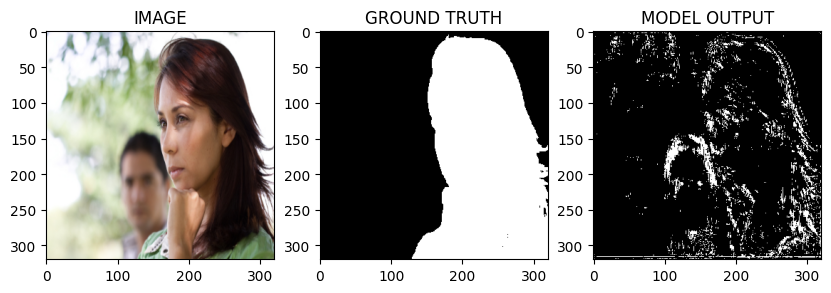

In [ ]:
# Display the original image, ground truth mask, and predicted mask using the helper function
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))